In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read data

In [2]:
data_path = os.path.join("datasets")

In [3]:
def load_data(filename, data_path=data_path):
    csv_path = os.path.join(data_path, filename)
    df = pd.read_csv(csv_path, sep = ";", decimal = ",", dayfirst=True, parse_dates = ['loan_date_created'])
    df['loan_date_created'] = pd.DatetimeIndex(df['loan_date_created']).month.astype(str) + "-" + pd.DatetimeIndex(df['loan_date_created']).year.astype(str)
    return df

In [4]:
train_data = load_data("data_DS_HW_train.csv")
test_data = load_data("data_DS_HW_test.csv")

# Data review with pandas-profiling

In [ ]:
from pandas_profiling import ProfileReport

In [ ]:
data = pd.concat([train_data, test_data])

In [ ]:
profile = ProfileReport(data,
title="Pandas Profiling Report",
    correlations={
        "pearson": {"calculate": False},
        "spearman": {"calculate": False},
        "kendall": {"calculate": False},
        "phi_k": {"calculate": False},
        "cramers": {"calculate": False},
    }
    )

In [ ]:
profile.to_file("output/reports/profiling_report.html");

Data statistics had been created by pandas_profiling library. Report is availabe in "\output\reports\profiling_report.html" directory.

In [5]:
train_data.dropna(subset = ["TARGET"], inplace=True)
y_train = train_data["TARGET"]

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data, y_train, test_size=0.2, random_state=42)

In [7]:
X_train = X_train.drop("TARGET", axis=1)

# Preprocessing pipeline

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_selector as selector

My selection

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameRemover(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(self.attribute_names, axis=1)

To fill nan values I'll use SimpleImputer with most frequent strategy for categorical data and median strategy for numerical data.
It seems the fastest approach to modeling. To limit of data amount I'll use "Feature Selection" in my pipeline.
Another way could be to drop columns where there are a lot of missing values or zeros and manually remove columns that seem unnecessary in solving the problem (no documentation explaining the columns).
Note: I think "Feature Selection" task could be executed before whole pipeline. It will be more efficiency because there would be no need to repeat this task.

## Pipeline for categorical data

In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy = "most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
        ('standardscaler', StandardScaler())
    ])

## Pipeline for numerical data

In [11]:
num_pipeline = Pipeline([
        #("select_cat", selector(dtype_exclude=object)),
        ("imputer", SimpleImputer(strategy = "median")),
        ('standardscaler', StandardScaler())
    ])

## Concatenate two pipelines with ColumnTransformer

In [12]:
from sklearn.compose import ColumnTransformer
column_transformer = ColumnTransformer(
    [
        ("cat_pipe", cat_pipeline, selector(dtype_include=object)),
        ("num_pipe", num_pipeline, selector(dtype_exclude=object))
    ]
)

## Preprocessing

In order to avoid overfitting models (without feature selection xgboost classifier was overfitted), achieve greater computational efficiency, reduce the occupied memory space, eliminate unnecessary and duplicate information, one of the feature selection methods was used: SelectFromModel.
Another way could be to use Pearson correlation feature elimination, Chi-square statistic feature elimination, Recursive feature elimination (RFE), Lasso/ridge regression feature elimination or combination of all of the above.

In [13]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

preprocess_pipeline = Pipeline([
        ("select_cat", DataFrameRemover(["application_id"])),
        ("column_transformer", column_transformer),
        ("feature_selection", SelectFromModel(RandomForestClassifier(random_state= 2017, n_estimators=100), max_features=50))
    ])

I used a version of k-fold cross-validation that preserves the imbalanced class distribution in each fold. It is called stratified k-fold cross-validation and will enforce the class distribution in each split of the data to match the distribution in the complete training dataset.

In [14]:
from sklearn.model_selection import StratifiedKFold

seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle = True)

# Grid solutions

In GridSearchCV, it is important that the gridded parameters are not at the extremes of the intervals!
Note: On my computer, some tasks count a few minutes, so this condition (for recruitment process) may not be fulfilled.

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [16]:
import warnings
warnings.filterwarnings('ignore')

Linear Support Vector Classifier

In [17]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

pipe_1 = Pipeline([('preprocessing', preprocess_pipeline),
                 ('classifier', LinearSVC(C=1))])

param_grid_1 = {
            'classifier__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
}

grid_1 = GridSearchCV(pipe_1, param_grid_1, cv=kfold, return_train_score=True)

grid_1.fit(X_train, y_train)
grid_1.best_params_

{'classifier__C': 1}

Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

pipe_2 = Pipeline([('preprocessing', preprocess_pipeline), ('classifier', LogisticRegression(C=1))])

param_grid_2 = {
            'classifier__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
}

grid_2 = GridSearchCV(pipe_2, param_grid_2, cv=kfold, return_train_score=True)

grid_2.fit(X_train, y_train)
grid_2.best_params_

{'classifier__C': 1}

k-Nearest Neighbors

In [19]:
from sklearn.neighbors import KNeighborsClassifier

pipe_3 = Pipeline([('preprocessing', preprocess_pipeline), ('classifier', KNeighborsClassifier(n_neighbors=2, metric='euclidean'))])

param_grid_3 = {
            'classifier__n_neighbors': [2, 5, 10, 11, 12, 15],
            'classifier__metric': ['euclidean', 'cityblock']
}


grid_3 = GridSearchCV(pipe_3, param_grid_3, cv=kfold, return_train_score=True)

grid_3.fit(X_train, y_train)
grid_3.best_params_

{'classifier__metric': 'cityblock', 'classifier__n_neighbors': 2}

Decision Tree Classifier

In [20]:
from sklearn.tree import DecisionTreeClassifier

pipe_4 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('classifier', DecisionTreeClassifier())])

param_grid_4 = {
            'classifier__max_depth': [5, 10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10, 30],
            'classifier__max_leaf_nodes': [3, 10, 20, 40]
}


grid_4 = GridSearchCV(pipe_4, param_grid_4, cv=kfold, return_train_score=True)

grid_4.fit(X_train, y_train)
grid_4.best_params_

{'classifier__max_depth': 5,
 'classifier__max_leaf_nodes': 3,
 'classifier__min_samples_split': 2}

Gradient Boosting Classifier

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

pipe_5 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('classifier', GradientBoostingClassifier(
                       n_estimators=1, 
                      learning_rate=0.5, 
                      random_state=42))
                  ])


param_grid_5 = {'classifier__n_estimators': [50, 100, 200],
              'classifier__learning_rate': [0.1, 0.2, 0.5, 0.9, 1]
             }

grid_5 = GridSearchCV(pipe_5, param_grid_5, cv=kfold, return_train_score=True)

grid_5.fit(X_train, y_train)
grid_5.best_params_

{'classifier__learning_rate': 0.5, 'classifier__n_estimators': 200}

Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

pipe_6 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('classifier', RandomForestClassifier(n_estimators=500, max_leaf_nodes=16))
                  ])

param_grid_6 = {'classifier__n_estimators': [10, 50, 100, 150],
              'classifier__max_leaf_nodes': [5, 10, 20],
              'classifier__max_depth': [10, 20, 30]
             }

grid_6 = GridSearchCV(pipe_6, param_grid_6, cv=kfold, return_train_score=True)

grid_6.fit(X_train, y_train)
grid_6.best_params_

{'classifier__max_depth': 10,
 'classifier__max_leaf_nodes': 20,
 'classifier__n_estimators': 50}

Bagging Classifier

In [23]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

pipe_7 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('classifier', BaggingClassifier(
                                    DecisionTreeClassifier(random_state=42), n_estimators=500,
                                    max_samples=100, bootstrap=True, random_state=42))
                  ])

param_grid_7 = {'classifier__n_estimators': [10,50,100],
              'classifier__max_samples': [10,20]
             }

grid_7 = GridSearchCV(pipe_7, param_grid_7, cv=kfold, return_train_score=True)

grid_7.fit(X_train, y_train)
grid_7.best_params_

{'classifier__max_samples': 20, 'classifier__n_estimators': 100}

Extra Trees Classifier

In [24]:
from sklearn.ensemble import ExtraTreesClassifier

pipe_8 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('classifier', ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16))
                  ])

param_grid_8 = {'classifier__n_estimators': [10, 50, 100],
              'classifier__max_leaf_nodes': [10, 20],
              'classifier__max_depth': [10, 20]
             }

grid_8 = GridSearchCV(pipe_8, param_grid_8, cv=kfold, return_train_score=True)

grid_8.fit(X_train, y_train)
grid_8.best_params_

{'classifier__max_depth': 20,
 'classifier__max_leaf_nodes': 20,
 'classifier__n_estimators': 10}

Adaptive Boosting

In [25]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

pipe_9 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('classifier', AdaBoostClassifier(
                        DecisionTreeClassifier(max_depth=1), 
                        n_estimators=1, learning_rate=0.5, 
                        algorithm="SAMME.R", random_state=42)
                   )
                  ])


param_grid_9 = {'classifier__n_estimators': [100, 200],
              'classifier__learning_rate': [0.1, 0.9, 1],
               'classifier__base_estimator__max_depth':[5, 10,20]
             }

grid_9 = GridSearchCV(pipe_9, param_grid_9, cv=kfold, return_train_score=True)

grid_9.fit(X_train, y_train)
grid_9.best_params_

{'classifier__base_estimator__max_depth': 20,
 'classifier__learning_rate': 0.9,
 'classifier__n_estimators': 200}

Extreme Gradient Boosting (xgboost)

In [26]:
from scipy.stats.distributions import uniform, randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost


pipe_10 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('classifier', xgboost.XGBClassifier(n_estimators=1, 
                      learning_rate=0.5, 
                      random_state=42))
                  ])


param_grid_10 = {
    'classifier__max_depth': randint(3, 11),
    'classifier__learning_rate': uniform(0.001, 0.1-0.001),
    'classifier__n_estimators': randint(50, 400),
    'classifier__gamma': uniform(0,2),
    'classifier__colsample_bytree': uniform(0.5, 0.5),
    'classifier__subsample': uniform(0.5, 0.5),
    'classifier__min_child_weight': randint(1, 11)
}

grid_10 = RandomizedSearchCV(n_iter=20,estimator=pipe_10, 
                             param_distributions=param_grid_10, 
                      cv=kfold, 
                      return_train_score=True)

grid_10.fit(X_train, y_train)
grid_10.best_params_

{'classifier__colsample_bytree': 0.7394920440696673,
 'classifier__gamma': 0.19131689786828887,
 'classifier__learning_rate': 0.05857934193829136,
 'classifier__max_depth': 10,
 'classifier__min_child_weight': 2,
 'classifier__n_estimators': 237,
 'classifier__subsample': 0.9039603130903919}

# Results

Results on test data.

In [35]:
from sklearn import  metrics


models = []
models.append((str(pipe_1.steps[-1][1]).split("(")[0], grid_1.best_estimator_))
models.append((str(pipe_2.steps[-1][1]).split("(")[0], grid_2.best_estimator_))
models.append((str(pipe_3.steps[-1][1]).split("(")[0], grid_3.best_estimator_))
models.append((str(pipe_4.steps[-1][1]).split("(")[0], grid_4.best_estimator_))
models.append((str(pipe_5.steps[-1][1]).split("(")[0], grid_5.best_estimator_))
models.append((str(pipe_6.steps[-1][1]).split("(")[0], grid_6.best_estimator_))
models.append((str(pipe_7.steps[-1][1]).split("(")[0], grid_7.best_estimator_))
models.append((str(pipe_8.steps[-1][1]).split("(")[0], grid_8.best_estimator_))
models.append((str(pipe_9.steps[-1][1]).split("(")[0], grid_9.best_estimator_))
models.append((str(pipe_10.steps[-1][1]).split("(")[0], grid_10.best_estimator_))

precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
roc_auc_score = []
for name, model in models:
    precision_score.append(metrics.precision_score(y_test , model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test , model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test , model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test , model.predict(X_test)))
    if (name == 'LinearSVC'):
        roc_auc_score.append(metrics.roc_auc_score(y_test , model.decision_function(X_test)))        
    else:    
        roc_auc_score.append(metrics.roc_auc_score(y_test , model.predict_proba(X_test)[:,1]))

train_accuracy_score = []
for name, model in models:
    train_accuracy_score.append(metrics.accuracy_score(y_train , model.predict(X_train)))

In [36]:
import pandas as pd
d = {'test_precision_score': precision_score,
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score,
     'roc_auc_score' : roc_auc_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=[model[0] for model in models])
df

,Method,test_precision_score,recall_score,f1_score,accuracy_score,roc_auc_score
0,LinearSVC,0.581818,0.131959,0.215126,0.7665,0.739584
1,LogisticRegression,0.548148,0.152577,0.238710,0.7640,0.741585
2,KNeighborsClassifier,0.636667,0.393814,0.486624,0.7985,0.810898
3,DecisionTreeClassifier,0.000000,0.000000,0.000000,0.7575,0.619939
4,GradientBoostingClassifier,0.728460,0.575258,0.642857,0.8450,0.874548
5,RandomForestClassifier,0.739130,0.070103,0.128060,0.7685,0.759700
6,BaggingClassifier,0.666667,0.004124,0.008197,0.7580,0.707778
7,ExtraTreesClassifier,0.333333,0.004124,0.008147,0.7565,0.728171
8,AdaBoostClassifier,0.961194,0.663918,0.785366,0.9120,0.921162
9,XGBClassifier,0.888298,0.688660,0.775842,0.9035,0.915167


Check if models are overfitted.

In [37]:
import pandas as pd
d = {
     'train_accuracy_score' : train_accuracy_score,
     'test_accuracy_score' : accuracy_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=[model[0] for model in models])
df

,Method,train_accuracy_score,test_accuracy_score
0,LinearSVC,0.785625,0.7665
1,LogisticRegression,0.784875,0.7640
2,KNeighborsClassifier,0.937125,0.7985
3,DecisionTreeClassifier,0.776500,0.7575
4,GradientBoostingClassifier,0.956625,0.8450
5,RandomForestClassifier,0.792250,0.7685
6,BaggingClassifier,0.776625,0.7580
7,ExtraTreesClassifier,0.778875,0.7565
8,AdaBoostClassifier,1.000000,0.9120
9,XGBClassifier,0.996750,0.9035


### Feature importances

In [38]:
feature_names = grid_1.best_estimator_[0][1].get_feature_names_out()\
    [grid_1.best_estimator_[0][-1].get_support()]
feature_importances = {"feature_names": feature_names}

for name, model in models:
    try:
        feature_importances[name] = model.named_steps['classifier'].feature_importances_
    except: None

Let's look which model is the most importance for ours models.

Text(0.5, 0.98, 'Feature importance')

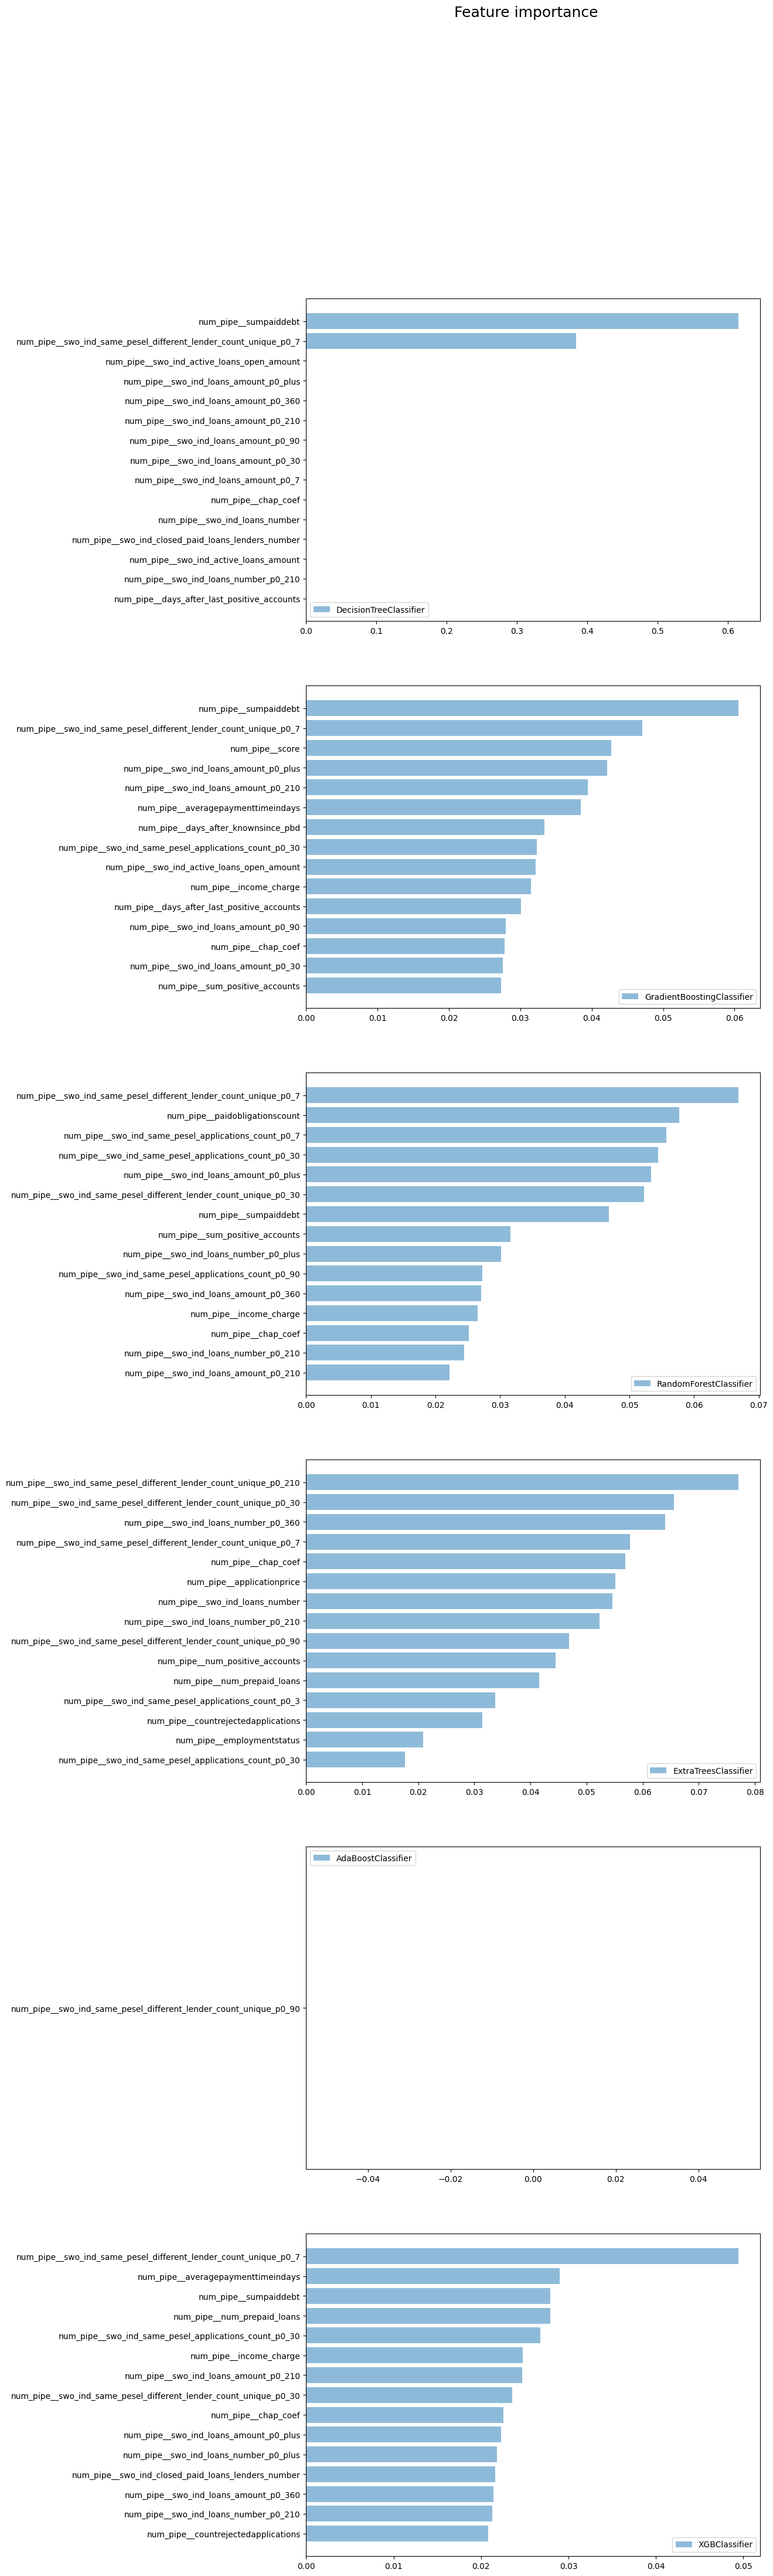

In [39]:
feature_importances_df = pd.DataFrame(data=feature_importances)
fig, axes = plt.subplots(figsize=(10, 50), nrows=len(feature_importances_df.columns[1:]))

i = 0
for col in feature_importances_df.columns[1:]:
    df = feature_importances_df.sort_values(by=col, ascending=True).iloc[-15:,:]
    axes[i].barh(df.feature_names, df[col], align='center', alpha =0.5, label=col)
    axes[i].legend()
    i += 1

fig.suptitle("Feature importance", fontsize=18)

LinearSVC
LogisticRegression
KNeighborsClassifier
DecisionTreeClassifier
GradientBoostingClassifier
RandomForestClassifier
BaggingClassifier
ExtraTreesClassifier
AdaBoostClassifier
XGBClassifier


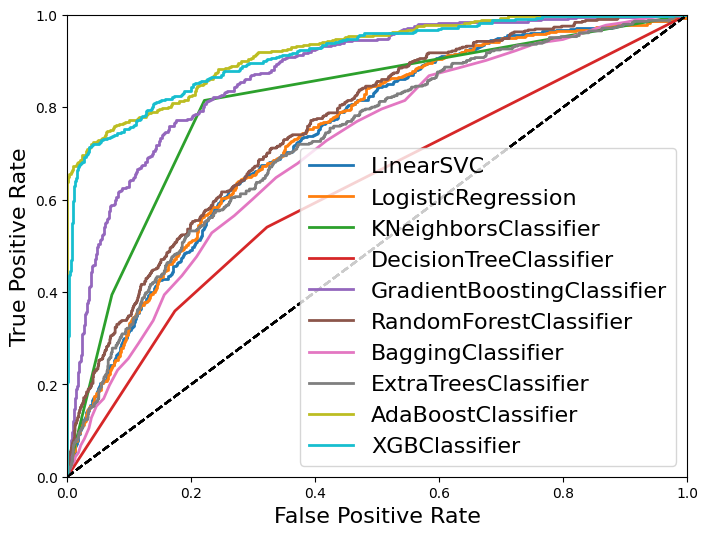

In [41]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
for name, model in models:
    print(name)
    if (name == 'LinearSVC'):
        y_scores = model.decision_function(X_test)
    else: 
        y_scores = model.predict_proba(X_test)[:,1]        
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    plot_roc_curve(fpr, tpr, name)

plt.legend(loc="lower right", fontsize=16)
plt.show()

# Save data

In [44]:
output = pd.DataFrame({'application_id': test_data.application_id, 'TARGET': grid_10.best_estimator_.predict(test_data)})
output.to_csv('output/predict.csv', index = False)

In [45]:
output = pd.DataFrame({'application_id': test_data.application_id, 'TARGET_proba': grid_10.best_estimator_.predict_proba(test_data)[:,1].round(4)})
output.to_csv('output/predict_proba.csv', index = False)